In [ ]:
!pip install optuna
!pip install swifter
!pip install contractions

# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 
import re

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
from gensim.models import Word2Vec

import nltk
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.util import ngrams

from wordcloud import WordCloud   # for the wordcloud
#nltk.download('all')

import string
import swifter
import contractions
import warnings

pd.options.display.max_rows = 100000
pd.options.display.max_colwidth = 1000

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import optuna

warnings.filterwarnings("ignore")

# Utility Functions

In [3]:
# list of model useful during model selection
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [4]:
def lemmatization(text):
    """
    Input   : text :<str> 
    Returns : lemmatized text <str>
    """
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(i) for i in text.split()])

def contract_fix(text):
    """
    Input   : text :<str> 
    Returns : text post replacing contractions <str>
    """
    return " ".join([contractions.fix(word) for word in text.split()])

def word_freq_func(corpus):
    """
    This function calculates frequency of unique tokens in the corpus
    Input   : corpus :<str> entire corpus of text
    
    Returns : word_freq_df <pandas.dataframe> 
    """
    word_freq = dict()
    for token in corpus.split():
        if token not in word_freq.keys():
            word_freq[token]=1
        else:
            word_freq[token]+= 1
        
    word_freq_df = pd.DataFrame({'words':word_freq.keys(),'values':word_freq.values()})
    word_freq_df = word_freq_df.sort_values(by='values',ascending=False)
    
    return word_freq_df

def noise_removal(text,stop_words):
    """
    This function cleans input text from stop words
    
    Input  : 
    
    text       : <str> text that needs to be cleaned 
    stop_words : <list> list of stop words that would be leveraged to clean the text
    
    return : <str>clean text without stopwords 
    """
    return " ".join(i for i in text.split() if i not in stop_words)

def replace_char(text):
    """
    Input   : text :<str> 
    Returns : <str>text post replacing &-and, $-dollar, %-percent
    """
    text = text.replace('&',' and ').replace('$',' dollar ').replace('%',' percent ')
    return text

def pos_tag_filtering(text):
    """
    Input   : text :<str> 
    Returns : <str>text post filtering for 'PROPN','VERB','NOUN','ADJ','ADV','AUX','CONJ','CCONJ'
    """
    doc = nlp(text)
    pos_filtered_list = [i for i in doc if i.pos_ in ['PROPN','VERB','NOUN','ADJ','ADV','AUX','CONJ','CCONJ']]
    pos_filtered_list = list(map(str,pos_filtered_list))
    return " ".join(pos_filtered_list)   

def model_selection(x,y,models,num_folds=10,scoring='roc_auc'):
    """
    This function helps find the best fit model for the problem, We have a set of basic
    models to help with classification problem 
    
    Input   : 
    
    num_folds : <int>number of cross validation folds,default=10
    scoring   : Any scoring metric from sklearn.metrics,default='roc_auc'
    x         : <pandas.dataframe> independent features dataframe
    y         : <pandas.series> dependent features series
    models    : list of ML models in this format : [('Model_Name',Model Constructor Call)] models = [('LR', LogisticRegression())]
    """
    seed = 7
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
        cv_results = cross_val_score(model, x, y, cv=kfold, scoring=scoring,n_jobs=-2)
        results.append(cv_results)
        names.append(name)
        msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
        print(msg)

def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 

In [5]:
stop_words = list(nlp.Defaults.stop_words)

In [6]:
#df = pd.read_csv('../input/nlp-getting-started/train.csv')
#df_submission = pd.read_csv('../input/nlp-getting-started/test.csv')
df = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

In [7]:
print('Shape of dataset',df.shape)
print('Shape of submission dataset',df_submission.shape)

Shape of dataset (7613, 5)
Shape of submission dataset (3263, 4)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Creating a corpus of raw text

In [9]:
corpus_list = df['text'].tolist()
corpus = " ".join(corpus_list)
vocab = list(set(corpus.split()))

In [10]:
print('Number of unique words in the vocabulary of raw text : ',len(vocab))

Number of unique words in the vocabulary of raw text :  31924


In [11]:
print('Few words from vocabulary : \n',vocab[:10])

Few words from vocabulary : 
 ['#2A', 'Humidity...', 'Jackson...calm', 'futurea', 'panicking?..', 'occurrence', 'Hate', 'Fitz', 'speed:', "Reddit's"]


#### Creation of word frequency dataframe & related analysis

In [12]:
word_freq_df = word_freq_func(corpus)

In [13]:
word_freq_df.head(10)

,words,values
3,the,2575
55,a,1845
23,to,1805
25,in,1757
5,of,1722
86,and,1302
87,I,1197
213,for,820
102,is,814
83,on,773


Text(0, 0.5, 'Mentions - @')

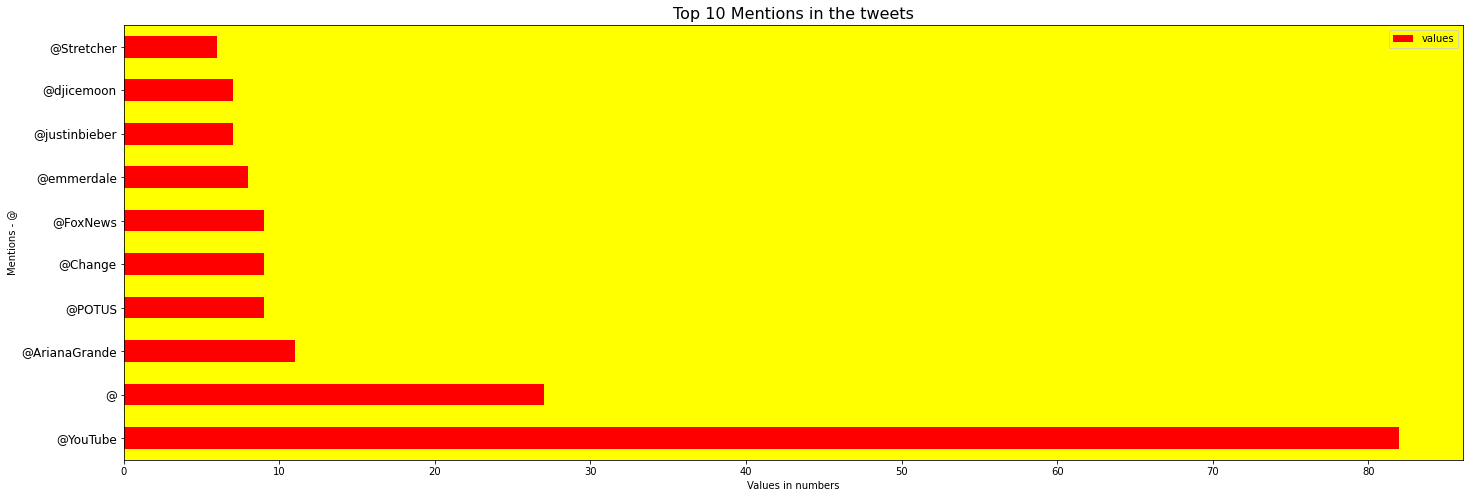

In [14]:
#Checking frequency of mentions (@) in the tweet raw corpus
plt.rcParams['axes.facecolor'] = 'yellow'
word_freq_df[word_freq_df['words'].str.startswith('@')].head(10).plot(x='words',y='values',kind='barh',color='red',figsize=(24,8))
plt.yticks(fontsize=12)
plt.title('Top 10 Mentions in the tweets', fontsize=16)
plt.xlabel('Values in numbers')
plt.ylabel('Mentions - @')

Text(0, 0.5, 'hashtags')

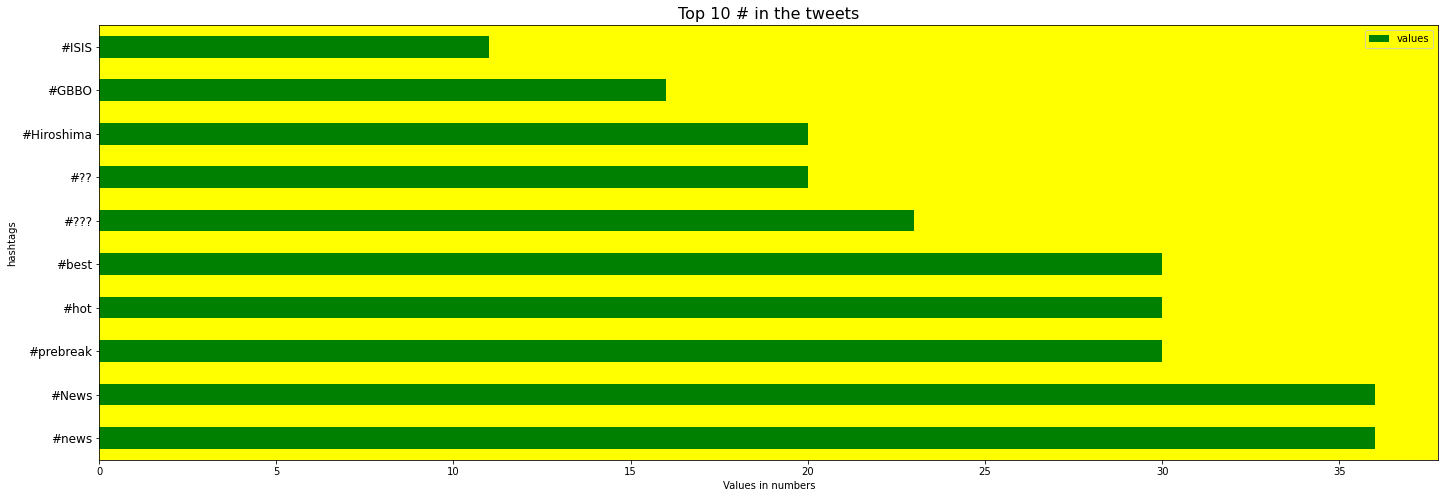

In [15]:
#Checking frequency of hashtags(#) in the corpus
word_freq_df[word_freq_df['words'].str.startswith('#')].head(10).plot(x='words',y='values',kind='barh',cmap='ocean',figsize=(24,8))
plt.yticks(fontsize=12)
plt.title('Top 10 # in the tweets', fontsize=16)
plt.xlabel('Values in numbers')
plt.ylabel('hashtags')

### Target Class distribution

Text(0, 0.5, 'no. of samples')

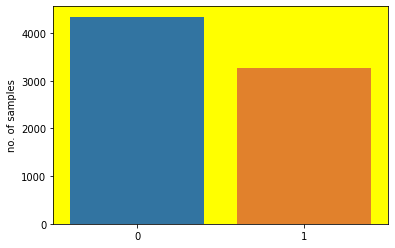

In [16]:
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('no. of samples')

### Text Pre-Processing

1. Noise Removal
2. Lexicon Normalization
3. Object Standardization

In [17]:
#Noise Removal - First we will lower the text
df['text_lowered'] = df['text'].str.lower()

#Replace apostrophe/short words in python
df['text_contraction_fixed'] = df['text_lowered'].swifter.apply(contract_fix)

#Remove http URLs from the text
df['text_url_removed'] = df['text_contraction_fixed'].swifter.apply(lambda x : re.sub(r'http\S+', '', x))

#Checking the tweets where we see punctation present
df['text_url_spclchar_removed'] = df['text_url_removed'].swifter.apply(lambda x : re.sub(r'[^&$%a-zA-Z]', ' ', x))

#Replacing few special chars with meaning
df['text_url_spclchar_removed'] = df['text_url_spclchar_removed'].swifter.apply(replace_char)

#stopwords removal 
df['text_url_spclchar_stop_removed'] = df['text_url_spclchar_removed'].swifter.apply(lambda x : noise_removal(x,stop_words))
#Lemmatization
nltk.download('omw-1.4')
df['lemmatized_text'] = df['text_url_spclchar_stop_removed'].swifter.apply(lemmatization)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\BIBHU\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

##### Validate if any special character

In [18]:
df['find_spcl_char'] = df['text_url_spclchar_removed'].swifter.apply(lambda x : 1 if re.search(r'[^\sa-zA-Z]',x) else 0)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [19]:
df.find_spcl_char.value_counts()

0    7613
Name: find_spcl_char, dtype: int64

#### POS Tagging

In [20]:
df['pos_filtered_text'] = df['lemmatized_text'].swifter.apply(pos_tag_filtering)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [21]:
cleaned_corpus = df['pos_filtered_text'].tolist()
cleaned_corpus = " ".join(cleaned_corpus)
vocab_clean = list(set(cleaned_corpus.split()))

# Generating ranked phrases using RAKE Algorithm

In [22]:
from rake_nltk import Rake
r = Rake(min_length=2, max_length=4,include_repeated_phrases=False)
text= ",".join(df['pos_filtered_text'])
r.extract_keywords_from_text(text)
ranked_pharases = r.get_ranked_phrases_with_scores()

In [23]:
ranked_pharases[:10]

[(16.0, 'wrinkled face deluge decayed'),
 (16.0, 'vibrator shaped vape busted'),
 (16.0, 'save save save heavydirtysoul'),
 (16.0, 'random hole broke street'),
 (16.0, 'mortal kombat sega version'),
 (16.0, 'ml sicily italy euroquake'),
 (16.0, 'missambear tweet quoted wired'),
 (16.0, 'mess daddy massacre becarefulharry'),
 (16.0, 'maximum wind gust speed'),
 (16.0, 'lobo paranoico mad men')]

# Wordcloud to see what defines a disaster and what does not

In [24]:
df["bigram_text"] = df["pos_filtered_text"].swifter.apply(get_ngrams, n=2)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [25]:
df["trigram_text"] = df["pos_filtered_text"].swifter.apply(get_ngrams, n=3)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

## Analyzing disaster = 1

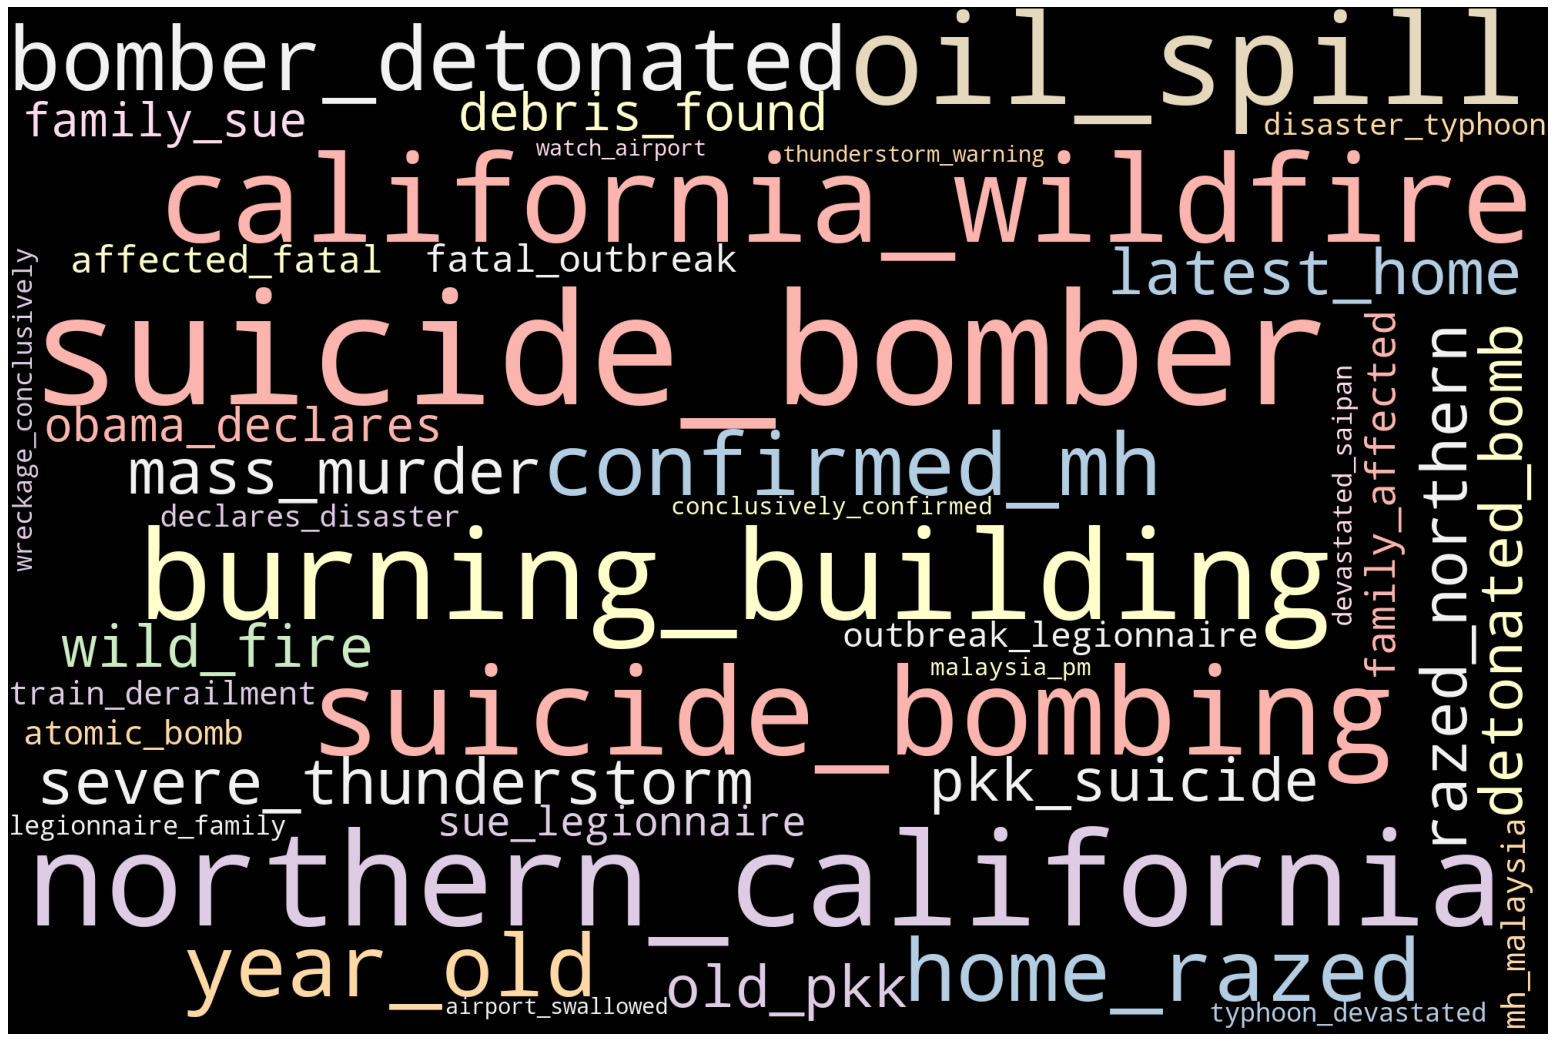

In [26]:
tweet_string_list = df[df['target']==1]['bigram_text'].tolist()
tweet_string = ' '.join(tweet_string_list)
wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 40, collocations=False, normalize_plurals=False).generate(tweet_string)
#Plot
plot_cloud(wordcloud)    

## Analyzing disaster = 0

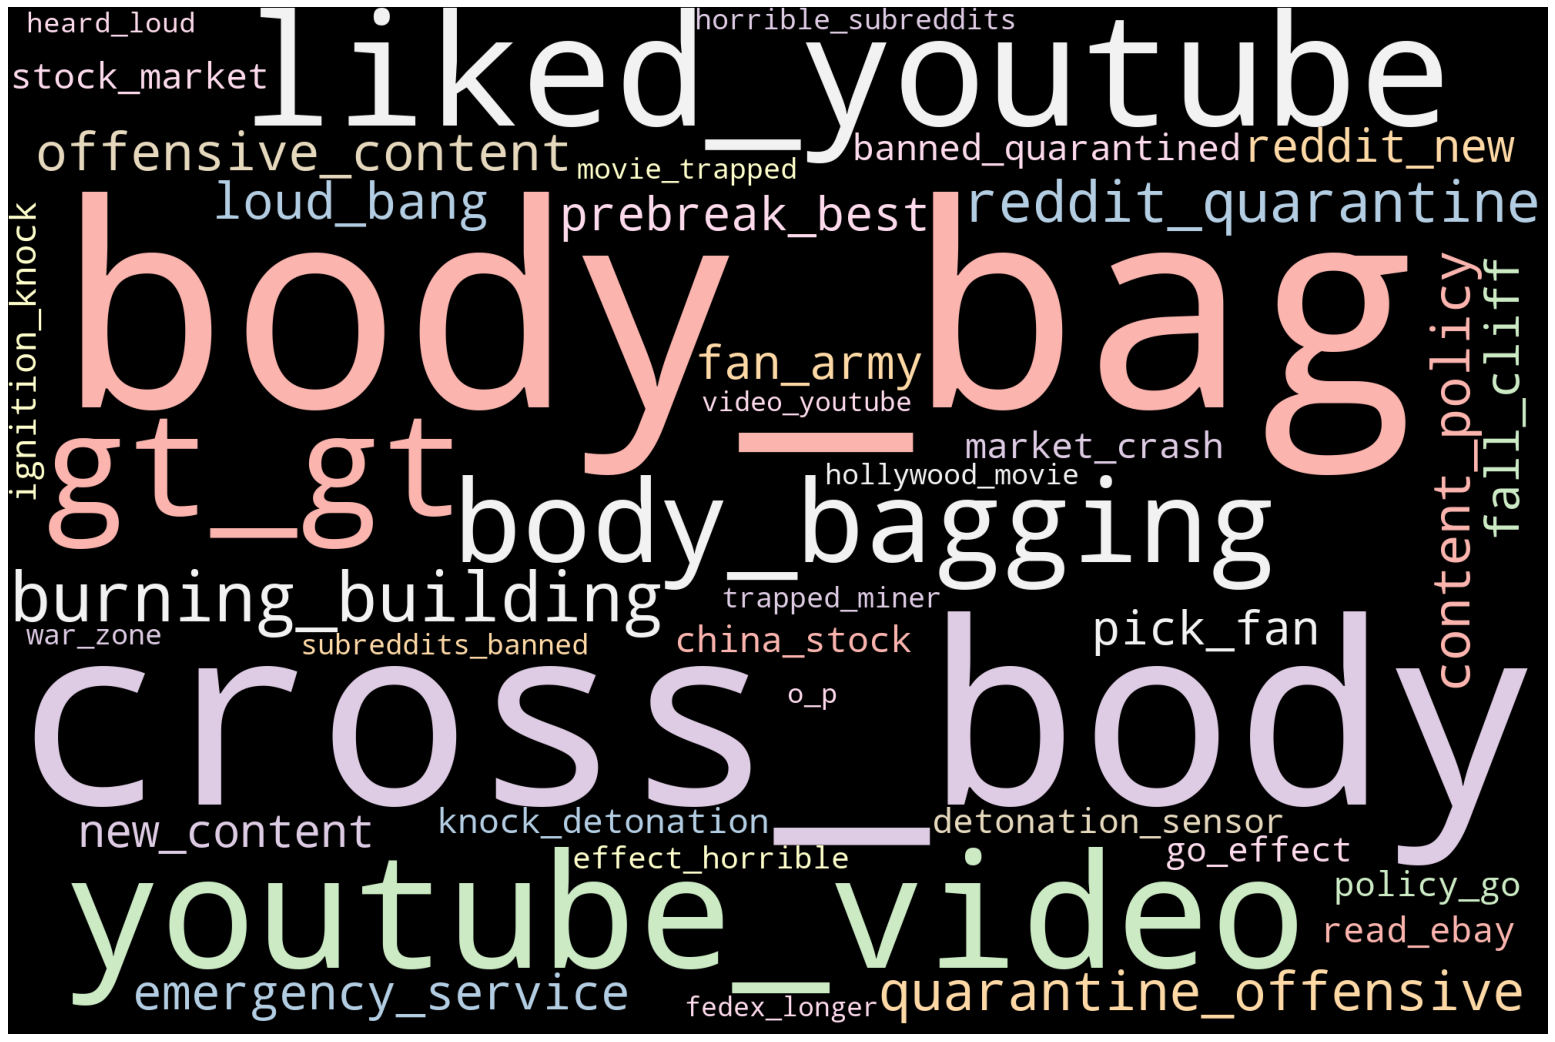

In [27]:
tweet_string_list = df[df['target']==0]['bigram_text'].tolist()
tweet_string = ' '.join(tweet_string_list)
wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 40, collocations=False, normalize_plurals=False).generate(tweet_string)
#Plot
plot_cloud(wordcloud)    

# Gensim Word2Vec

In [28]:
df['pos_filtered_text_tokenized'] = df['pos_filtered_text'].swifter.apply(gensim.utils.simple_preprocess)

In [29]:
w2v_model = gensim.models.Word2Vec(vector_size=100,
                                   window=10,
                                   min_count=2)

w2v_model.build_vocab(df['pos_filtered_text_tokenized'], progress_per=1000)
w2v_model.train(df['pos_filtered_text_tokenized'], total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(264631, 311205)

In [30]:
w2v_model.save("./word2vec-nlp-disaster-tweet.model")

In [31]:
w2v_model.wv.most_similar('disaster')

[('typhoon', 0.9993031620979309),
 ('nuclear', 0.9992892742156982),
 ('weapon', 0.9992146492004395),
 ('new', 0.9991957545280457),
 ('help', 0.9991920590400696),
 ('day', 0.9991793036460876),
 ('world', 0.9991379976272583),
 ('look', 0.9991359710693359),
 ('news', 0.9991324543952942),
 ('people', 0.9991227984428406)]

In [119]:
def SentenceVectorGen(text_list):
    if len(text_list)>1:
        doc2vecarray = np.array([w2v_model.wv.get_vector(token) for token in text_list if token in set(w2v_model.wv.index_to_key) ] )
        doc2vecarray = (np.sum(doc2vecarray,axis=0)/len(doc2vecarray)).reshape(1,-1)
    else:
        doc2vecarray = np.zeros((1,100))
    return doc2vecarray

In [33]:
df['sentence_vector'] = df['pos_filtered_text_tokenized'].swifter.apply(SentenceVectorGen)

Pandas Apply:   0%|          | 0/7613 [00:00<?, ?it/s]

In [34]:
df['size_sentence_vector'] = df['sentence_vector'].apply(np.shape)

## X-Y Split

In [35]:
x =[x[0] for x in df['sentence_vector']]
y= df['target'].values

## Train,Test Split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [38]:
# Check if x & y are compliant for sklearn fit
from sklearn.utils import check_X_y
check_X_y(x_train,y_train)

(array([[-0.07213735,  0.18076713,  0.09436847, ..., -0.08973905,
          0.0266741 ,  0.03189601],
        [-0.05803554,  0.16816956,  0.08822017, ..., -0.08406523,
          0.02859764,  0.03225386],
        [-0.09417453,  0.24970911,  0.13009311, ..., -0.1205832 ,
          0.03879487,  0.04597593],
        ...,
        [-0.07413491,  0.18779923,  0.09354956, ..., -0.08985826,
          0.02817331,  0.0371043 ],
        [-0.06675653,  0.16704619,  0.08672696, ..., -0.08113272,
          0.03009919,  0.03067793],
        [-0.06596905,  0.17646642,  0.08981624, ..., -0.08353569,
          0.03123964,  0.03077055]]),
 array([1, 0, 0, ..., 1, 0, 1], dtype=int64))

## Model Selection using Word2Vec Gensim Model - Averaging

In [39]:
model_selection(x,y,models)

LR 0.639674 0.009061 
KNN 0.680680 0.020690 
CART 0.601265 0.019144 
SVM 0.632480 0.006434 
RF 0.729272 0.012595 
GBM 0.703207 0.011560 


> We will be going with Random Forest model and will be trying to tune it

# Prediction Dataset - Preprocessing

Cleaning Submission Dataframe and make it prediction ready

In [43]:
#Noise Removal - First we will lower the text
df_submission['text_lowered'] = df_submission['text'].str.lower()

#Replace apostrophe/short words in python
df_submission['text_contraction_fixed'] = df_submission['text_lowered'].swifter.apply(contract_fix)

#Remove http URLs from the text
df_submission['text_url_removed'] = df_submission['text_contraction_fixed'].swifter.apply(lambda x : re.sub(r'http\S+', '', x))

#Checking the tweets where we see punctation present
df_submission['text_url_spclchar_removed'] = df_submission['text_url_removed'].swifter.apply(lambda x : re.sub(r'[^&$%a-zA-Z]', ' ', x))

#Replacing few special chars with meaning
df_submission['text_url_spclchar_removed'] = df_submission['text_url_spclchar_removed'].swifter.apply(replace_char)

#stopwords removal 
df_submission['text_url_spclchar_stop_removed'] = df_submission['text_url_spclchar_removed'].swifter.apply(lambda x : noise_removal(x,stop_words))

#Lemmatization
df_submission['lemmatized_text'] = df_submission['text_url_spclchar_stop_removed'].swifter.apply(lemmatization)

#pos filtering
df_submission['pos_filtered_text'] = df_submission['lemmatized_text'].swifter.apply(pos_tag_filtering)

#pos_tokenization
df_submission['pos_filtered_text_tokenized'] = df_submission['pos_filtered_text'].swifter.apply(gensim.utils.simple_preprocess)

#Sentence_Vector Conversiona
df_submission['sentence_vector'] = df_submission['pos_filtered_text_tokenized'].swifter.apply(SentenceVectorGen)

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

# Hyper-Parameter Tuning using Optuna

In [50]:
import sklearn
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100,1000)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return sklearn.model_selection.cross_val_score(clf, x, y, scoring='roc_auc',
           n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-21 21:06:08,796] A new study created in memory with name: no-name-688ca0b7-78c7-49df-9283-62292a29694e
[I 2022-08-21 21:06:30,592] Trial 0 finished with value: 0.6590878287666334 and parameters: {'n_estimators': 803, 'max_depth': 11.469483922948207}. Best is trial 0 with value: 0.6590878287666334.
[I 2022-08-21 21:07:00,643] Trial 1 finished with value: 0.6643898653049792 and parameters: {'n_estimators': 923, 'max_depth': 30.121937168694352}. Best is trial 1 with value: 0.6643898653049792.
[I 2022-08-21 21:07:14,543] Trial 2 finished with value: 0.6475891178683856 and parameters: {'n_estimators': 746, 'max_depth': 7.083737035903114}. Best is trial 1 with value: 0.6643898653049792.
[I 2022-08-21 21:07:23,571] Trial 3 finished with value: 0.6540600242331923 and parameters: {'n_estimators': 392, 'max_depth': 9.93449416782698}. Best is trial 1 with value: 0.6643898653049792.
[I 2022-08-21 21:07:24,452] Trial 4 finished with value: 0.6143580885798268 and parameters: {'n_estimator

[I 2022-08-21 21:16:18,654] Trial 39 finished with value: 0.6560581121040253 and parameters: {'n_estimators': 114, 'max_depth': 12.977055159686707}. Best is trial 17 with value: 0.6644191864221508.
[I 2022-08-21 21:16:30,861] Trial 40 finished with value: 0.6620747481521642 and parameters: {'n_estimators': 369, 'max_depth': 26.36588737196237}. Best is trial 17 with value: 0.6644191864221508.
[I 2022-08-21 21:17:01,794] Trial 41 finished with value: 0.6650084140150533 and parameters: {'n_estimators': 910, 'max_depth': 31.96140397805724}. Best is trial 41 with value: 0.6650084140150533.
[I 2022-08-21 21:17:32,222] Trial 42 finished with value: 0.6631234008475572 and parameters: {'n_estimators': 911, 'max_depth': 22.548573529829095}. Best is trial 41 with value: 0.6650084140150533.
[I 2022-08-21 21:17:55,344] Trial 43 finished with value: 0.6623708006572963 and parameters: {'n_estimators': 696, 'max_depth': 27.51397115397368}. Best is trial 41 with value: 0.6650084140150533.
[I 2022-08-21

[I 2022-08-21 21:31:57,540] Trial 78 finished with value: 0.6655219776046514 and parameters: {'n_estimators': 776, 'max_depth': 28.702052479662953}. Best is trial 55 with value: 0.6656337490475324.
[I 2022-08-21 21:32:19,406] Trial 79 finished with value: 0.6613660905966471 and parameters: {'n_estimators': 676, 'max_depth': 29.0839619786231}. Best is trial 55 with value: 0.6656337490475324.
[I 2022-08-21 21:32:44,379] Trial 80 finished with value: 0.6616533321885673 and parameters: {'n_estimators': 781, 'max_depth': 22.65108058153974}. Best is trial 55 with value: 0.6656337490475324.
[I 2022-08-21 21:33:12,070] Trial 81 finished with value: 0.6652601119296755 and parameters: {'n_estimators': 860, 'max_depth': 25.41292859498259}. Best is trial 55 with value: 0.6656337490475324.
[I 2022-08-21 21:33:35,342] Trial 82 finished with value: 0.6629855984798326 and parameters: {'n_estimators': 718, 'max_depth': 28.134366486458333}. Best is trial 55 with value: 0.6656337490475324.
[I 2022-08-21 

In [51]:
trial = study.best_trial
print('Roc_Auc: {}'.format(trial.value))

Roc_Auc: 0.6656337490475324


Best Params : 'n_estimators': 838, 
'max_depth': 20.937368984373013

# Prediction using RF

In [58]:
rf = RandomForestClassifier(n_estimators=838,max_depth=21)

In [59]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=21, n_estimators=838)

In [61]:
y_pred_class = rf.predict(x_test)

In [70]:
print(f"Accuracy Score : {metrics.accuracy_score(y_test, y_pred_class)}")
print(f"Confusion Matrix : \n {metrics.confusion_matrix(y_test, y_pred_class)}")
print(metrics.classification_report(y_test,y_pred_class))
y_pred_prob = rf.predict_proba(x_test)[:, 1]
print(f"ROC AUC Score :{metrics.roc_auc_score(y_test, y_pred_prob)}")

Accuracy Score : 0.696953781512605
Confusion Matrix : 
 [[921 170]
 [407 406]]
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1091
           1       0.70      0.50      0.58       813

    accuracy                           0.70      1904
   macro avg       0.70      0.67      0.67      1904
weighted avg       0.70      0.70      0.69      1904

ROC AUC Score :0.7339165463148674


In [191]:
x_pred =[x[0] for x in df_submission['sentence_vector']]

In [192]:
df_submission['size_sentence_vector'] = df_submission['sentence_vector'].apply(np.shape)

In [193]:
df_submission['size_sentence_vector'].value_counts()

(1, 100)    3257
(1, 1)         6
Name: size_sentence_vector, dtype: int64

In [195]:
for i in range(len(x_pred)):
    if x_pred[i].shape != (100,):
        x_pred[i] = np.array([[0.000000]*100],dtype='float32').reshape((100,))

In [196]:
df_submission['target'] = rf.predict(x_pred)

In [197]:
df_submission['target'].value_counts()

0    2287
1     976
Name: target, dtype: int64

In [198]:
df_out = df_submission[['id','target']]
df_out.to_csv('./submission.csv',index=False)